<a href="https://colab.research.google.com/github/Onedory/yolov5-art-analyze/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터셋 및 데이터로더 구성

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

# 라벨 인코딩 매핑 생성
train_annotations_file = '/content/drive/MyDrive/Data/train/csv/annotations.csv'
val_annotations_file = '/content/drive/MyDrive/Data/validation/csv/annotations.csv'
train_img_labels = pd.read_csv(train_annotations_file)
val_img_labels = pd.read_csv(val_annotations_file)
label_to_idx = {label: idx for idx, label in enumerate(train_img_labels['label'].unique())}

# 라벨 인코딩 함수 정의
def encode_label(label):
    return label_to_idx[label]

class ObjectDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0].split('/')[-1])
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, IOError):
            return None, None

        label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(encode_label(label))  # Label을 tensor로 변환
        if self.transform:
            image = self.transform(image)
        return image, label

def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None and b[1] is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.dataloader.default_collate(batch)

# 데이터 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 및 데이터로더 생성
train_img_dir = '/content/drive/MyDrive/Data/train/images'
val_img_dir = '/content/drive/MyDrive/Data/validation/images'
train_dataset = ObjectDataset(annotations_file=train_annotations_file, img_dir=train_img_dir, transform=transform)
val_dataset = ObjectDataset(annotations_file=val_annotations_file, img_dir=val_img_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# 데이터로더 설정
dataloaders = {
    'train': train_loader,
    'val': val_loader
}


# 2. 전이 학습 모델 설계

In [ ]:
import torch.nn as nn
from torchvision import models

# Pretrained ResNet 모델 로드
model = models.resnet18(pretrained=True)

# 마지막 레이어 수정 (클래스 수에 맞게 조정)
num_ftrs = model.fc.in_features
num_classes = len(label_to_idx)  # 클래스 수 계산
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

# 모델을 GPU로 이동 (가능한 경우)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


In [ ]:
pip install tqdm


# 3. 모델 훈련

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
from tqdm import tqdm
import numpy as np

# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 정규화(weight_decay 추가)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning rate decay

# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, path='/content/drive/MyDrive/transferlearning_best.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# 모델 훈련 함수 정의
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='/content/drive/MyDrive/transferlearning_best.pth')

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 epoch에 대해 훈련 및 검증 단계 설정
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 훈련 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터 반복
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} phase', leave=False):
                if inputs.size(0) == 0:  # 빈 배치 무시
                    continue

                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # forward
                # 훈련 단계에서만 연산 기록 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 훈련 단계에서만 역전파 + 옵티마이저 단계 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 손실 기록
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            # 모델 복사 (검증 정확도가 개선된 경우)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            # Early stopping 적용
            if phase == 'val':
                early_stopping(epoch_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    model.load_state_dict(torch.load('/content/drive/MyDrive/transferlearning_best.pth'))
                    return model, train_losses, val_losses

    print(f'Best val Acc: {best_acc:4f}')

    # 가장 좋은 모델 가중치 로드
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses

# 모델 훈련
model, train_losses, val_losses = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, patience=5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 0/24
----------


train Loss: 0.1922 Acc: 0.9284


val Loss: 11.5370 Acc: 0.2514
Validation loss decreased (inf --> 11.537049).  Saving model ...
Epoch 1/24
----------


train Loss: 0.1391 Acc: 0.9517


val Loss: 2.9278 Acc: 0.2686
Validation loss decreased (11.537049 --> 2.927807).  Saving model ...
Epoch 2/24
----------


train Loss: 0.1201 Acc: 0.9600


val Loss: 0.1143 Acc: 0.8155
Validation loss decreased (2.927807 --> 0.114258).  Saving model ...
Epoch 3/24
----------


train Loss: 0.1106 Acc: 0.9636


val Loss: 0.1239 Acc: 0.8155
EarlyStopping counter: 1 out of 5
Epoch 4/24
----------


train Loss: 0.0964 Acc: 0.9690


val Loss: 0.7031 Acc: 0.6143
EarlyStopping counter: 2 out of 5
Epoch 5/24
----------


train Loss: 0.0891 Acc: 0.9709


val Loss: 0.0877 Acc: 0.8254
Validation loss decreased (0.114258 --> 0.087732).  Saving model ...
Epoch 6/24
----------


train Loss: 0.0832 Acc: 0.9735


val Loss: 0.1284 Acc: 0.8096
EarlyStopping counter: 1 out of 5
Epoch 7/24
----------


train Loss: 0.0485 Acc: 0.9853


val Loss: 0.0719 Acc: 0.8341
Validation loss decreased (0.087732 --> 0.071920).  Saving model ...
Epoch 8/24
----------


train Loss: 0.0326 Acc: 0.9902


val Loss: 0.0781 Acc: 0.8337
EarlyStopping counter: 1 out of 5
Epoch 9/24
----------


train Loss: 0.0224 Acc: 0.9938


val Loss: 0.0821 Acc: 0.8334
EarlyStopping counter: 2 out of 5
Epoch 10/24
----------


train Loss: 0.0146 Acc: 0.9958


val Loss: 0.1015 Acc: 0.8320
EarlyStopping counter: 3 out of 5
Epoch 11/24
----------


train Loss: 0.0092 Acc: 0.9973


val Loss: 0.1038 Acc: 0.8313
EarlyStopping counter: 4 out of 5
Epoch 12/24
----------


train Loss: 0.0057 Acc: 0.9985


val Loss: 0.1140 Acc: 0.8316
EarlyStopping counter: 5 out of 5
Early stopping


# 4.손실 그래프 그리기

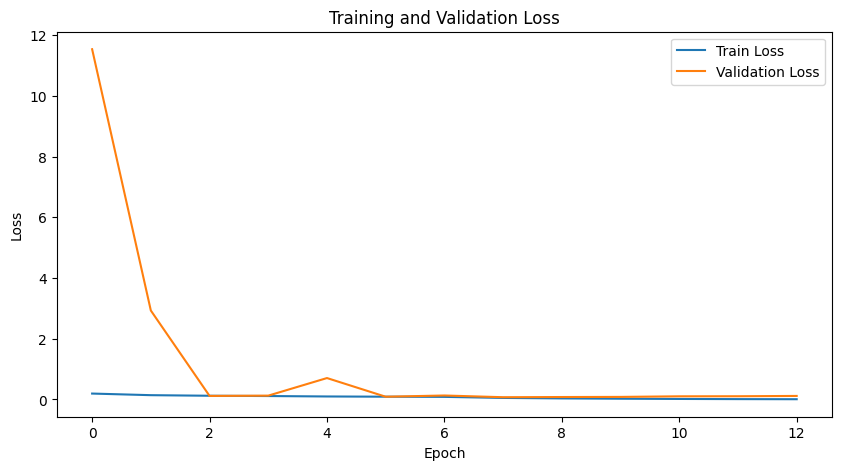

In [ ]:
import matplotlib.pyplot as plt

# 훈련 및 검증 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
